In [1]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Input, Lambda, GlobalAveragePooling2D
import numpy as np
#from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import random
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
import tensorflow as tf
from keras.models import Model
from keras.backend.tensorflow_backend import set_session
import pandas.util.testing as tm
import seaborn as sns

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        visible_device_list='0',
        allow_growth=True))
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
batch_size = 32
epochs = 5

In [3]:
def print_confusionmatrix(true_test,preds_test):
  #y_test = np.argmax(y_pred)
  #y_pred = np.argmax(y_pred)

  df = tm.DataFrame(confusion_matrix(true_test,preds_test))
  plt.figure(figsize = (10,10))
  sns.heatmap(df,annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
  #plt.savefig('figure0.png')

  acc_score = accuracy_score(true_test,preds_test)
  rec_score = recall_score(true_test,preds_test, average=None)
  pre_score = precision_score(true_test,preds_test, average=None)
  f1__score = f1_score(true_test,preds_test, average=None)
  print("acc_score: ",acc_score)
  print("error rate: ",1-acc_score)
  print("rec_score: ",rec_score)
  print("pre_score: ",pre_score)
  print("f1_score: ",f1__score)

chestX 

0 : Benign

1 : Malignant

In [4]:
x_train = np.load('/content/drive/My Drive/data/chestx/X_train_299x299.npy')
y_train = np.load('/content/drive/My Drive/data/chestx/Y_train_299x299.npy')
x_test = np.load('/content/drive/My Drive/data/chestx/X_test_299x299.npy')
y_test = np.load('/content/drive/My Drive/data/chestx/Y_test_299x299.npy')

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1800, 299, 299, 1)
1800 train samples
540 test samples


In [6]:
x_train, y_train = shuffle(x_train, y_train)
x_train_normal, y_train_normal = x_train.copy(), y_train.copy()

In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

87916544/87910968 [==============================] - 8s 0us/step


In [8]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_normal, y_train_normal = shuffle(x_train_normal, y_train_normal) 
model.fit(x_train_normal, y_train_normal, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 121s 67ms/step - loss: 0.3090 - accuracy: 0.8639 - val_loss: 0.5792 - val_accuracy: 0.6722
Epoch 2/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0947 - accuracy: 0.9650 - val_loss: 0.3354 - val_accuracy: 0.8630
Epoch 3/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0462 - accuracy: 0.9844 - val_loss: 0.2232 - val_accuracy: 0.9037
Epoch 4/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0453 - accuracy: 0.9850 - val_loss: 0.0905 - val_accuracy: 0.9648
Epoch 5/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0230 - accuracy: 0.9939 - val_loss: 0.0795 - val_accuracy: 0.9741


In [9]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

540/540 [==============================] - 7s 12ms/step
Test loss: 0.07947339103729636
Test accuracy: 0.9740740656852722


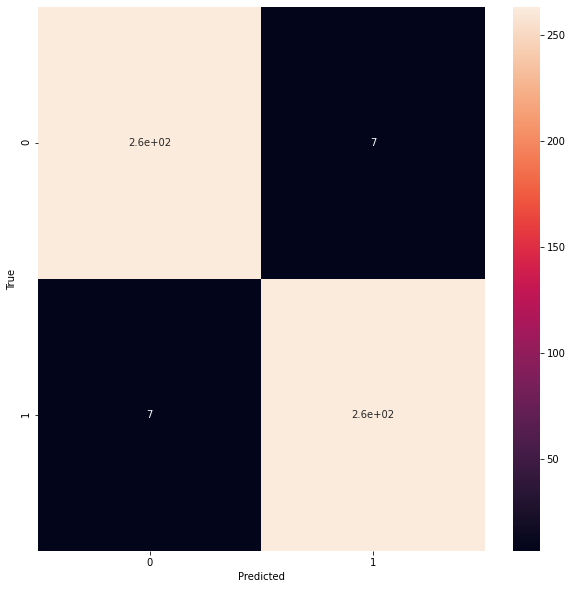

acc_score:  0.9740740740740741
error rate:  0.025925925925925908
rec_score:  [0.97407407 0.97407407]
pre_score:  [0.97407407 0.97407407]
f1_score:  [0.97407407 0.97407407]


In [10]:
true_test = np.argmax(y_test,axis=1)
preds_test = np.argmax(model.predict(x_test), axis=1)
print_confusionmatrix(true_test,preds_test)